# Few Shot Learning

A technique in machine learning where a model is trained to perform tasks with only a few labeled examples per class. It's particularly useful in scenarios where obtaining a large amount of labeled data is challenging

### Load Necessary Libraries

In [7]:
!pip install matplotlib
!pip install tqdm

import math
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tqdm
import torch.optim as optim

# Inline plotting for matplotlib
%matplotlib inline


### Load and Preprocess Dataset

GEI (Gait Energy Image) is a widely used representation in action and gait recognition tasks. It is a 2D image that encodes the motion and posture of a subject during walking or performing an action.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
prototypical_accuarcy = 0
matching_accuracy = 0
relation_accuracy = 0

image_width = 224
image_height = 224

data_dir = "/content/drive/MyDrive/_projects/GEI_Project/Dataset_fewshot"  # Replace with your path


### 1. Prototypical Network

A type of neural network designed for few-shot learning. They aim to classify new samples by comparing them to class "prototypes" in a learned embedding

In [10]:
def load_data(data_dir, image_size):
    """
    Load GEI images from the specified directory.

    Args:
        data_dir (str): Path to the data directory.
        image_size (tuple): Size to resize images (default is 64x64).

    Returns:
        dict: Dictionary with class names as keys and list of images as values.
    """
    data = {}
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            images = []
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image = Image.open(image_path).convert('L').resize(image_size)
                images.append(np.array(image) / 255.0)  # Normalize pixel values
            data[class_name] = np.array(images)
    return data

image_size = (image_width, image_height)
data = load_data(data_dir, image_size)


In [11]:
def split_support_query(data, support_size=5):
    """
    Split each class's data into support and query sets.

    Args:
        data (dict): Dictionary containing images for each class.
        support_size (int): Number of samples per class for the support set.

    Returns:
        dict, dict: Support set and query set dictionaries.
    """
    support_set = {}
    query_set = {}
    for class_name, images in data.items():
        support, query = train_test_split(images, train_size=support_size, random_state=42)
        support_set[class_name] = support
        query_set[class_name] = query
    return support_set, query_set

support_size = 5
support_set, query_set = split_support_query(data, support_size)


In [12]:
def compute_prototypes(support_set):
    """
    Compute class prototypes (mean of support images).

    Args:
        support_set (dict): Support set with images for each class.

    Returns:
        dict: Prototypes for each class.
    """
    prototypes = {}
    for class_name, images in support_set.items():
        prototypes[class_name] = np.mean(images, axis=0)
    return prototypes

prototypes = compute_prototypes(support_set)


In [13]:
def classify_query(query_set, prototypes):
    """
    Classify query samples using Euclidean distance to prototypes.

    Args:
        query_set (dict): Query set with images for each class.
        prototypes (dict): Class prototypes.

    Returns:
        list, list: Predicted labels and true labels for the query set.
    """
    predictions = []
    true_labels = []
    class_names = list(prototypes.keys())

    for class_name, images in query_set.items():
        for image in images:
            distances = [np.linalg.norm(image - prototypes[proto_class]) for proto_class in class_names]
            predicted_class = class_names[np.argmin(distances)]
            predictions.append(predicted_class)
            true_labels.append(class_name)
    return predictions, true_labels

predictions, true_labels = classify_query(query_set, prototypes)


In [14]:
prototypical_accuarcy = accuracy_score(true_labels, predictions)
print(f"Prototypial Accuracy: {prototypical_accuarcy * 100:.2f}%")


Prototypial Accuracy: 69.61%


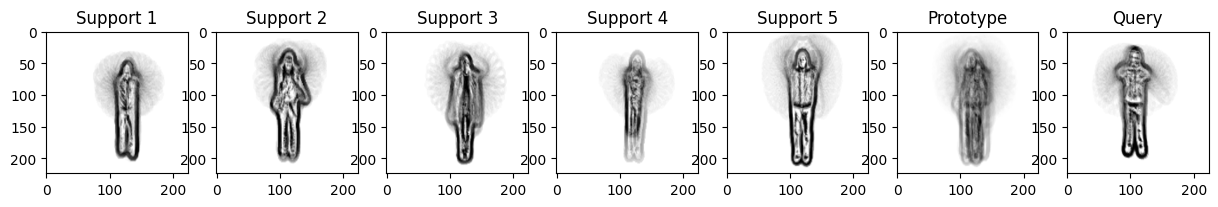

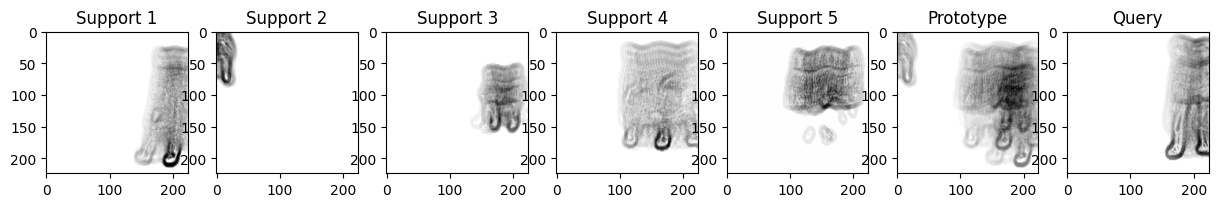

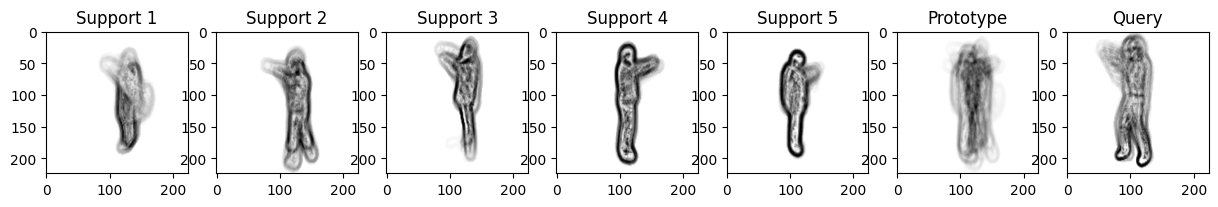

In [15]:
def plot_samples(prototypes, support_set, query_set):
    """
    Visualize support images, prototypes, and query samples.
    """
    class_names = prototypes.keys()
    for class_name in class_names:
        fig, axes = plt.subplots(1, len(support_set[class_name]) + 2, figsize=(15, 5))
        for i, img in enumerate(support_set[class_name]):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Support {i+1}")
        axes[len(support_set[class_name])].imshow(prototypes[class_name], cmap='gray')
        axes[len(support_set[class_name])].set_title("Prototype")
        for i, img in enumerate(query_set[class_name][:1]):  # Show 1 query for simplicity
            axes[len(support_set[class_name]) + 1 + i].imshow(img, cmap='gray')
            axes[len(support_set[class_name]) + 1 + i].set_title(f"Query")
        plt.show()

plot_samples(prototypes, support_set, query_set)


### 2. Matching Network

Matching networks, in general, proposes a framework which learns a network that maps a small training dataset and test unlabeled example to same embeddings space. Matching networks aim to learn the proper embeddings representation of small training dataset and use differentiable k-NN with cosine similarity measure to ensure whether a test data point is something ever seen or not.

In [16]:
def create_npy_from_folders(data_dir, img_size):
    """
    Converts images in subfolders of `data_dir` into a numpy array and saves it as `data.npy`.
    Args:
        data_dir (str): Path to the dataset folder.
        img_size (tuple): Target size for resizing images (width, height).
    Returns:
        numpy.ndarray: The dataset array with shape (n_classes, n_samples, img_size[0], img_size[1]).
    """
    all_classes = sorted(os.listdir(data_dir))  # Sort to ensure consistency
    all_images = []
    min_samples = float('inf')  # Track the minimum number of images per class

    # Collect images and find the smallest class size
    for class_folder in all_classes:
        class_path = os.path.join(data_dir, class_folder)
        if not os.path.isdir(class_path):
            continue  # Skip non-folder entries
        class_images = []

        for img_file in sorted(os.listdir(class_path)):  # Sort to keep consistent order
            img_path = os.path.join(class_path, img_file)

            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                # Open, convert to grayscale, and resize the image
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(img_size)
                class_images.append(np.array(img))  # Add image as numpy array

        # Update the minimum number of samples across classes
        min_samples = min(min_samples, len(class_images))
        all_images.append(class_images)

    # Truncate all classes to the same number of samples (min_samples)
    truncated_images = [class_images[:min_samples] for class_images in all_images]

    # Convert to numpy array with consistent shape
    dataset = np.array(truncated_images)
    print(f"Dataset shape: {dataset.shape}")  # Should be (n_classes, min_samples, img_height, img_width)

    # Save to data.npy
    np.save('data.npy', dataset)
    return dataset

dataset = create_npy_from_folders(data_dir, img_size=(image_width, image_height))

Dataset shape: (3, 98, 224, 224)


In [17]:
# Load the newly created data.npy
x = np.load('data.npy')  # Shape should be (3, 98, 224, 224)

# Print original dataset shape
print(f"Dataset shape: {x.shape}")

# Ensure the dataset is reshaped to include the channel dimension (grayscale -> 1 channel)
x = np.reshape(x, newshape=(x.shape[0], x.shape[1], 224, 224, 1))  # Shape becomes (3, 98, 224, 224, 1)

# Shuffle the dataset (shuffling is applied to all classes together)
np.random.shuffle(x)

# Split dataset into train, val, and test sets
# Let's allocate 70% to training, 15% to validation, and 15% to test (this can be adjusted)
train_size = int(0.7 * x.shape[1])  # 70% of the samples per class
val_size = int(0.15 * x.shape[1])   # 15% of the samples per class
test_size = x.shape[1] - train_size - val_size  # Remaining 15%

x_train = x[:, :train_size, :, :, :]  # Select the first 'train_size' images for each class
x_val = x[:, train_size:train_size+val_size, :, :, :]  # Select the next 'val_size' images
x_test = x[:, train_size+val_size:, :, :, :]  # Select the remaining images for testing

# Print the shape of each split
print(f"Train shape: {x_train.shape}")
print(f"Val shape: {x_val.shape}")
print(f"Test shape: {x_test.shape}")

Dataset shape: (3, 98, 224, 224)
Train shape: (3, 68, 224, 224, 1)
Val shape: (3, 14, 224, 224, 1)
Test shape: (3, 16, 224, 224, 1)


##### Preprocess Images: Here we have use normalization method.

In [18]:
# Normalize the dataset
def processes_batch(data, mu, sigma):
    return (data - mu) / sigma

x_train = processes_batch(x_train, np.mean(x_train), np.std(x_train))
x_val = processes_batch(x_val, np.mean(x_val), np.std(x_val))
x_test = processes_batch(x_test, np.mean(x_test), np.std(x_test))

# Define dataset dictionary

dataset = {"train": x_train, "val": x_val, "test": x_test}

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")
# Now you can use `dataset['train']`, `dataset['val']`, and `dataset['test']` for training.

x_train shape: (3, 68, 224, 224, 1)
x_val shape: (3, 14, 224, 224, 1)
x_test shape: (3, 16, 224, 224, 1)


class 0


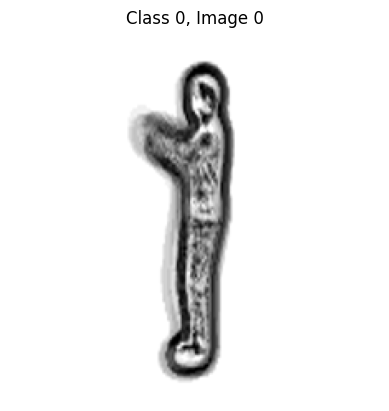

class 1


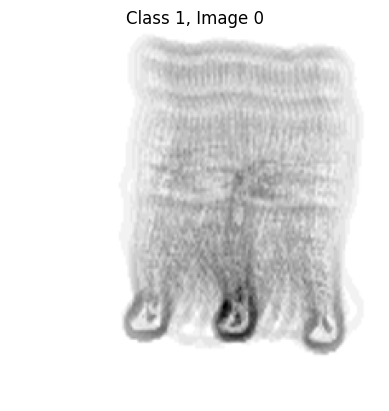

class 2


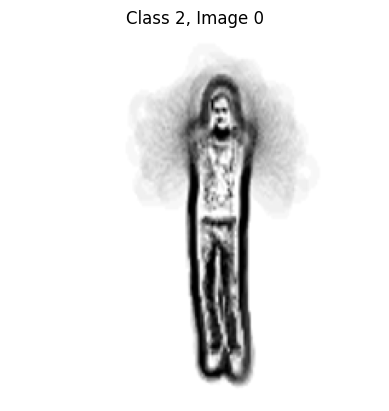

In [19]:
for class_idx in range(x_train.shape[0]):  # Loop over classes (3 classes in your case)
    print("class " + str(class_idx))
    # Extract the first image from the current class
    first_image = x_train[class_idx, 0, :, :]  # (height, width)

    # Plot the first image of each class
    plt.figure()
    plt.imshow(first_image, cmap='gray')  # Display as grayscale
    plt.title(f"Class {class_idx}, Image 0")  # Add a title with class index and image number
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

###### Step 3: Training Data Processing
To Load dataset, and prepare it for Matching Networks Architecture, we need to create:
1. Label Set: Variable choose_label
2. Support Set: support_set_x, support_set_y
3. Batch from Suppport Set Examples

Let's first create a batch which can give a support set, and target set.

In [20]:
def sample_batch(data):
    """
    Generates a sample batch.
    :param data: Dataset with shape [total_classes, total_samples, image_height, image_width, num_channels]
    :return: [support_set_x, support_set_y, target_x, target_y] for Matching Networks
    """
    support_set_x = np.zeros((batch_size, classes_per_set, samples_per_class, data.shape[2],
                              data.shape[3], data.shape[4]), np.float32)
    support_set_y = np.zeros((batch_size, classes_per_set, samples_per_class), np.int32)

    target_x = np.zeros((batch_size, data.shape[2], data.shape[3], data.shape[4]), np.float32)
    target_y = np.zeros((batch_size, 1), np.int32)

    for i in range(batch_size):
        # Randomly choose `classes_per_set` classes
        chosen_classes = np.random.choice(data.shape[0], size=classes_per_set, replace=False)
        # Randomly select one class as the target class
        target_class_idx = np.random.choice(classes_per_set, size=1)
        # Randomly select `samples_per_class + 1` samples for support and target
        chosen_samples = np.random.choice(data.shape[1], size=samples_per_class + 1, replace=False)

        # Extract the data for the selected classes
        x_temp = data[chosen_classes]
        x_temp = x_temp[:, chosen_samples]  # Shape: [classes_per_set, samples_per_class + 1, height, width, channels]

        # Generate the labels
        y_temp = np.arange(classes_per_set)  # Labels: [0, 1, ..., classes_per_set - 1]

        # Assign to support and target sets
        support_set_x[i] = x_temp[:, :-1]  # All except the last sample
        support_set_y[i] = np.expand_dims(y_temp[:], axis=1)  # Expand to match dimensions
        target_x[i] = x_temp[target_class_idx, -1]  # The last sample of the chosen target class
        target_y[i] = y_temp[target_class_idx]  # Corresponding label for the target

    return support_set_x, support_set_y, target_x, target_y


def get_batch(dataset_name):
    """
    Generate a batch while training.
    :param dataset_name: The name of the dataset ("train", "val", "test").
    :return: A batch of images and labels.
    """
    support_set_x, support_set_y, target_x, target_y = sample_batch(dataset[dataset_name])

    # Reshape support set to merge classes and samples into a single sequence
    support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                           support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
    support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])

    return support_set_x, support_set_y, target_x, target_y


If you recall, Matching Networks architecture, you will remember that there are mainly 4 parts of network:
1. Embeddings extractor(g)
2. Full-Context Embeddings(f)
2. Attention Model(a)
3. Distance Function(c)



so, In this section first we will create a classifier.

##### Step 4: Create an Embeddings extractor

In [21]:
def convLayer(in_channels, out_channels, dropout_prob=0.0):
    """
    A convolutional layer followed by ReLU, BatchNorm, MaxPool, and Dropout.
    """
    cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),  # 3x3 Conv, padding=1 to keep size
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2
        nn.Dropout(dropout_prob)  # Dropout layer to prevent overfitting
    )
    return cnn_seq
class Embeddings_extractor(nn.Module):
    def __init__(self, layer_size=64, num_channels=1, dropout_prob=0.5, image_size=224):
        super(Embeddings_extractor, self).__init__()

        self.layer1 = convLayer(num_channels, layer_size, dropout_prob)
        self.layer2 = convLayer(layer_size, layer_size * 2, dropout_prob)  # Increase filters
        self.layer3 = convLayer(layer_size * 2, layer_size * 2, dropout_prob)
        self.layer4 = convLayer(layer_size * 2, layer_size * 4, dropout_prob)  # Increase filters again

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))  # Pooling halved size 4 times
        self.outSize = finalSize * finalSize * layer_size * 4  # Adjusted for increased channels

    def forward(self, image_input):
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.reshape(x.size()[0], -1)  # Flatten to (batch_size, out_features)
        return x


##### step 5: Create an Attention model after classifier.
a(x,x^)= softmax of cosine similarities

In [22]:
class AttentionalClassify(nn.Module):
    def __init__(self, num_classes):
        super(AttentionalClassify, self).__init__()
        self.num_classes = num_classes

    def forward(self, similarities, support_set_y):
        """
        Products pdfs over the support set classes for the target set image.
        :param similarities: A tensor with cosine similarities of size [batch_size, sequence_length]
        :param support_set_y: One-hot tensor of shape [batch_size, sequence_length, num_classes]
        :return: Softmax pdf with shape [batch_size, num_classes]
        """
        # Apply Softmax to similarities along sequence dimension (dim=1)
        softmax = nn.Softmax(dim=1)
        softmax_similarities = softmax(similarities)

        # Calculate weighted sum of support set labels based on similarity scores
        preds = softmax_similarities.unsqueeze(1).bmm(support_set_y).squeeze(1)
        return preds

#### Step 6: Create a Distance Network, which will take output from Test Image, and training embeddings, to calculate the Distance.

find cosine similarities between support set and input_test_image

In [23]:
class DistanceNetwork(nn.Module):
    """
    This model calculates the cosine distance between each of the support set embeddings and
    the target image embeddings.
    """

    def __init__(self, embedding_dim=64):
        super(DistanceNetwork, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, support_set, input_image):
        """
        forward pass
        :param support_set: The embeddings of the support set images, shape [n_classes, n_samples, embedding_dim]
        :param input_image: The embedding of the target image, shape [batch_size, embedding_dim]
        :return: similarities, shape [batch_size, n_classes]
        """
        eps = 1e-10
        similarities = []

        # Loop over each class in the support set
        for class_embeddings in support_set:
            # Calculate cosine similarity for all images in the current class with input_image
            sum_support = torch.sum(torch.pow(class_embeddings, 2), 1)
            support_magnitude = sum_support.clamp(eps, float("inf")).rsqrt()

            # Cosine similarity for each image in the support set with input image
            dot_product = input_image.unsqueeze(1).bmm(class_embeddings.unsqueeze(2)).squeeze()
            cosine_similarity = dot_product * support_magnitude
            similarities.append(cosine_similarity)

        # Stack similarities to get shape [batch_size, n_classes]
        similarities = torch.stack(similarities)
        return similarities.t()

##### Step 7:  Create a Bi-directional LSTM, which is taking input and output from Test-image, and put them in same embeddings space.  
If we wish to use full-context embeddings, Matching Networks introduced Bi-directional LSTM for it.

In [24]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim):
        super(BidirectionalLSTM, self).__init__()
        """
        Initialize a multi-layer Bidirectional LSTM
        :param layer_size: a list of each layer's size (e.g., [128, 64] for two layers)
        :param batch_size: Batch size used during training
        :param vector_dim: The dimensionality of the input vector (e.g., the embedding size)
        """
        self.batch_size = batch_size
        self.hidden_size = layer_size[0]  # The size of the hidden layer
        self.vector_dim = vector_dim  # The size of the input vector (embedding dim)
        self.num_layer = len(layer_size)  # Number of LSTM layers

        # Create the LSTM layer with bidirectional setting
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=self.num_layer,
                            hidden_size=self.hidden_size, bidirectional=True)

        # Initialize hidden state and cell state for LSTM
        self.hidden = (
            Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size), requires_grad=False),
            Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size), requires_grad=False)
        )

    def repackage_hidden(self, h):
        """Wraps hidden states in new Variables to detach them from their history."""
        if type(h) == torch.Tensor:
            return Variable(h.data)
        else:
            return tuple(self.repackage_hidden(v) for v in h)

    def forward(self, inputs):
        """
        Forward pass through the Bidirectional LSTM
        :param inputs: Input sequence of shape [batch_size, sequence_length, embedding_dim]
        :return: Output of LSTM with shape [batch_size, sequence_length, hidden_size * 2]
        """
        self.hidden = self.repackage_hidden(self.hidden)  # Detach hidden states to avoid backpropagation through time
        output, self.hidden = self.lstm(inputs, self.hidden)
        return output


##### Step 8: Let's club all small modules we made, and create a matching network.

In [25]:

class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob, batch_size=32, num_channels=1, learning_rate=1e-3, fce=False, num_classes_per_set=3,
                 num_samples_per_class=98, image_size=224):
        """
        Matching Network
        :param keep_prob: dropout rate
        :param batch_size:
        :param num_channels:
        :param learning_rate:
        :param fce: Flag indicating whether to use full context embeddings (apply an LSTM on the CNN embeddings)
        :param num_classes_per_set:
        :param num_samples_per_class:
        :param image_size:
        """
        super(MatchingNetwork, self).__init__()
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.num_classes_per_set = num_classes_per_set
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size

        # Define the embedding extractor (CNN)
        self.g = Embeddings_extractor(layer_size=64, num_channels=num_channels, dropout_prob=keep_prob, image_size=image_size)

        # Flag for full-context embeddings (LSTM)
        self.f = fce  # if we are considering full-context embeddings

        # Define the cosine distance network
        self.c = DistanceNetwork()  # cosine distance among embeddings

        # Define the attentional classification layer
        self.a = AttentionalClassify(self.num_classes_per_set)  # softmax of cosine distance of embeddings

        # If using full-context embeddings, define LSTM
        if self.f:
            self.lstm = BidirectionalLSTM(layer_size=[32], batch_size=self.batch_size, vector_dim=self.g.outSize)

    def forward(self, support_set_images, support_set_y_one_hot, target_image, target_y):
        encoded_images = []
        for i in range(support_set_images.size(1)):  # Loop over sequence length
            gen_encode = self.g(support_set_images[:, i, :, :])  # Extract embedding for each support set image
            encoded_images.append(gen_encode)

        gen_encode = self.g(target_image)  # Extract embedding for the target image
        encoded_images.append(gen_encode)

        output = torch.stack(encoded_images, dim=0)

        if self.f:
            output = self.lstm(output)

        similarities = self.c(support_set=output[:-1], input_image=output[-1])
        preds = self.a(similarities, support_set_y=support_set_y_one_hot)

        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())

        crossentropy_loss = F.cross_entropy(preds, target_y.long())

        return accuracy, crossentropy_loss



#### Step 9: Create a Dataset Loader.
For our case, as we are using Omniglot Dataset,it will create a Omnligloat builder which calls Matching Network, and run its epochs for training, testing, and validation purpose.

In [26]:
num_classes_per_set = 3
def run_epoch(total_train_batches, name='train'):
    """
    Run the training epoch for Matching Network.
    :param total_train_batches: Number of batches to train on.
    :param name: 'train' or 'val' for training or validation phase.
    :return: Average cross-entropy loss and accuracy for the epoch.
    """
    total_c_loss = 0.0
    total_accuracy = 0.0

    # Loop through the batches
    for i in range(int(total_train_batches)):
        # Get the current batch (support set, target image, labels)
        x_support_set, y_support_set, x_target, y_target = get_batch(name)

        # Convert numpy arrays to PyTorch tensors
        x_support_set = Variable(torch.from_numpy(x_support_set)).float()
        y_support_set = Variable(torch.from_numpy(y_support_set), requires_grad=False).long()
        x_target = Variable(torch.from_numpy(x_target)).float()
        y_target = Variable(torch.from_numpy(y_target), requires_grad=False).long().squeeze()

        # One-hot encode the support set labels
        sequence_length = y_support_set.size(1)  # Number of images per class in support set
        batch_size = y_support_set.size(0)
        y_support_set_one_hot = Variable(
            torch.zeros(batch_size, sequence_length, num_classes_per_set).scatter_(2, y_support_set.unsqueeze(2), 1),
            requires_grad=False
        )

        # Reshape support set and target images to match the input format
        x_support_set = x_support_set.permute(0, 1, 4, 2, 3)  # [batch_size, sequence_length, 1, 224, 224]
        x_target = x_target.permute(0, 3, 1, 2)  # [batch_size, 1, 224, 224]

        # Forward pass through Matching Network
        acc, c_loss = matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

        # If in training mode, perform optimization
        if name == 'train':
            optimizer.zero_grad()
            c_loss.backward()
            optimizer.step()

        # Logging for this iteration
        iter_out = f"{name}_loss: {c_loss:.4f}, {name}_accuracy: {acc:.4f}"
        print(iter_out)  # Optionally log to a file or tensorboard

        # Accumulate loss and accuracy
        total_c_loss += c_loss.item()
        total_accuracy += acc.item()

    # Calculate average loss and accuracy over the entire epoch
    total_c_loss /= total_train_batches
    total_accuracy /= total_train_batches

    return total_c_loss, total_accuracy


In [27]:
batch_size = 20
num_channels = 1  # Assuming grayscale
lr = 1e-3
image_size = 224  # Based on your dataset
classes_per_set = 3  # Adjusted to match your dataset's 3 classes
samples_per_class = 1
keep_prob = 0.0  # No dropout (adjust if needed)
fce = True  # Full Context Embeddings, set to True as in your previous model
optim = "adam"
wd = 0  # No weight decay

# Initialize the Matching Network with the appropriate parameters
matchNet = MatchingNetwork(keep_prob, batch_size, num_channels, lr, fce, classes_per_set, samples_per_class, image_size)

# Optimizer setup
optimizer = torch.optim.Adam(matchNet.parameters(), lr=lr, weight_decay=wd)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

# Training setup
total_epochs = 5
total_train_batches = 20  # Number of batches for training
total_val_batches = 5  # Number of batches for validation
total_test_batches = 5  # Number of batches for testing


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


##### Let's Run Experiments !!!!!

In [28]:
# Initialize lists to store loss and accuracy for each phase
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(total_epochs):
    ############################### Training Step ##########################################
    train_c_loss, train_acc = run_epoch(total_train_batches, name='train')
    train_loss.append(train_c_loss)
    train_accuracy.append(train_acc)

    ############################### Validation Step ########################################
    val_c_loss, val_acc = run_epoch(total_val_batches, name='val')
    val_loss.append(val_c_loss)
    val_accuracy.append(val_acc)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{total_epochs}: "
          f"train_loss: {train_c_loss:.4f}, train_accuracy: {train_acc:.4f}, "
          f"val_loss: {val_c_loss:.4f}, val_accuracy: {val_acc:.4f}")

# Optional: Save results to a log or file


train_loss: 1.1171, train_accuracy: 0.2000
train_loss: 1.0271, train_accuracy: 0.6500
train_loss: 1.0556, train_accuracy: 0.6000
train_loss: 1.0538, train_accuracy: 0.4000
train_loss: 1.0613, train_accuracy: 0.3000
train_loss: 1.0195, train_accuracy: 0.4000
train_loss: 0.9171, train_accuracy: 0.7500
train_loss: 1.0401, train_accuracy: 0.3000
train_loss: 0.8999, train_accuracy: 0.6500
train_loss: 1.0274, train_accuracy: 0.4500
train_loss: 0.9508, train_accuracy: 0.5000
train_loss: 0.9291, train_accuracy: 0.6500
train_loss: 0.9576, train_accuracy: 0.5500
train_loss: 0.8824, train_accuracy: 0.7000
train_loss: 1.0076, train_accuracy: 0.4500
train_loss: 0.8977, train_accuracy: 0.6500
train_loss: 0.9457, train_accuracy: 0.6000
train_loss: 0.9130, train_accuracy: 0.7000
train_loss: 0.8787, train_accuracy: 0.7500
train_loss: 0.9829, train_accuracy: 0.5000
val_loss: 1.0213, val_accuracy: 0.5000
val_loss: 0.9996, val_accuracy: 0.4500
val_loss: 0.9941, val_accuracy: 0.4500
val_loss: 1.0334, val_a

Now Let's obtain our test accuracy by running the following code block:

In [29]:
total_test_c_loss, matching_accuracy = run_epoch(total_test_batches,'test')
print("matching_accuracy:{}%".format(matching_accuracy*100))

test_loss: 0.9248, test_accuracy: 0.7000
test_loss: 0.9262, test_accuracy: 0.7500
test_loss: 0.9301, test_accuracy: 0.6500
test_loss: 0.9427, test_accuracy: 0.6500
test_loss: 0.9011, test_accuracy: 0.7000
matching_accuracy:68.99999856948853%


#### Step 10: Let's visualize our results

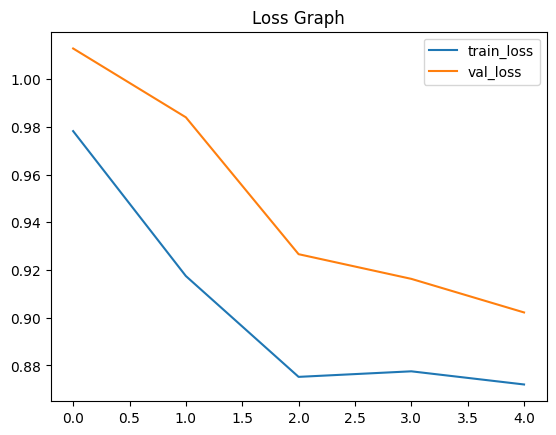

In [30]:
def plot_loss(train,val,name1="train_loss",name2="val_loss",title=""):
    plt.title(title)
    plt.plot(train, label=name1)
    plt.plot(val, label=name2)
    plt.legend()

plot_loss(train_loss,val_loss,"train_loss","val_loss","Loss Graph")

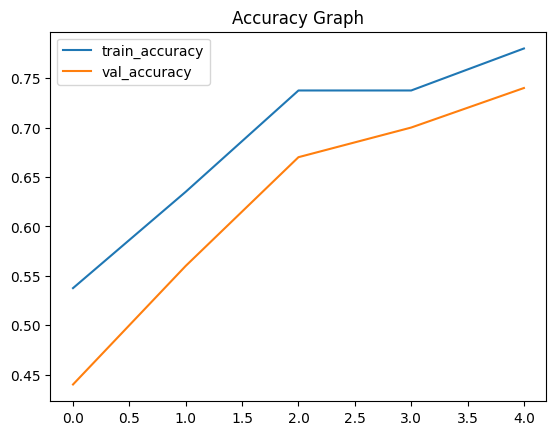

In [31]:
plot_loss(train_accuracy,val_accuracy,"train_accuracy","val_accuracy","Accuracy Graph")

### 3. Relation Network

Relation Networks (RNs) are designed for few-shot learning by explicitly learning relationships between query and support examples. They use a neural network to dynamically model similarity, enabling flexible and effective classification with minimal labeled data.

##### Step 1: Create a Relation Network

In [32]:
# Custom dataset for loading images from folders
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Feature extractor (e.g., CNN)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        out = self.conv(x)
        return out.view(x.size(0), -1)  # Flatten

# Relation module
class RelationModule(nn.Module):
    def __init__(self, input_dim):
        super(RelationModule, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.fc(x)

# Few-shot relation network
class RelationNetwork(nn.Module):
    def __init__(self, feature_dim, relation_dim):
        super(RelationNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.relation_module = RelationModule(feature_dim + relation_dim)

    def forward(self, support, query):
        support_features = self.feature_extractor(support)  # (N_way * K_shot, feature_dim)
        query_features = self.feature_extractor(query)      # (N_query, feature_dim)

        N_query = query_features.size(0)
        N_support = support_features.size(0)

        query_features = query_features.unsqueeze(1).expand(-1, N_support, -1)
        support_features = support_features.unsqueeze(0).expand(N_query, -1, -1)

        combined = torch.cat((query_features, support_features), dim=-1)
        relations = self.relation_module(combined.view(-1, combined.size(-1)))
        return relations.view(N_query, N_support)


##### Step 2: Training the Relation Network

In [33]:
total_epoches = 20

# Metrics storage
train_loss = []
train_accuracy = []

In [37]:
# Training example
def train_relation_network():
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((image_width, image_height)),
        transforms.ToTensor(),
    ])

    # Load dataset
    dataset = FewShotDataset(root_dir=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Initialize model
    feature_dim = 64 * 56 * 56  # Derived from conv + pooling
    model = RelationNetwork(feature_dim=feature_dim, relation_dim=feature_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()

    for epoch in range(total_epoches):
        epoch_loss = 0
        correct = 0
        total = 0

        for batch in dataloader:
            support, query = batch[0][:8], batch[0][8:]
            support_labels, query_labels = batch[1][:8], batch[1][8:]

            relations = model(support, query)
            target = (query_labels.unsqueeze(1) == support_labels.unsqueeze(0)).float()

            loss = criterion(relations, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            predicted = (relations > 0.5).float()
            correct += (predicted == target).sum().item()
            total += target.numel()

        epoch_accuracy = correct / total
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        relation_accuracy = epoch_accuracy
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Relation Accuracy: {epoch_accuracy:.4f}")

        if epoch_accuracy > 0.7:
          break


In [38]:
# Run training
train_relation_network()

Epoch 1, Loss: 29.7180, Relation Accuracy: 0.6832
Epoch 2, Loss: 33.9638, Relation Accuracy: 0.6592
Epoch 3, Loss: 31.4145, Relation Accuracy: 0.6832
Epoch 4, Loss: 30.5099, Relation Accuracy: 0.6952
Epoch 5, Loss: 31.1678, Relation Accuracy: 0.6858
Epoch 6, Loss: 31.4967, Relation Accuracy: 0.6772
Epoch 7, Loss: 31.6612, Relation Accuracy: 0.6704
Epoch 8, Loss: 34.7039, Relation Accuracy: 0.6644
Epoch 9, Loss: 31.4145, Relation Accuracy: 0.6832
Epoch 10, Loss: 31.9079, Relation Accuracy: 0.6884
Epoch 11, Loss: 32.9770, Relation Accuracy: 0.6695
Epoch 12, Loss: 33.3882, Relation Accuracy: 0.6704
Epoch 13, Loss: 36.1842, Relation Accuracy: 0.6336
Epoch 14, Loss: 33.8816, Relation Accuracy: 0.6601
Epoch 15, Loss: 32.8125, Relation Accuracy: 0.6738
Epoch 16, Loss: 32.5658, Relation Accuracy: 0.6738
Epoch 17, Loss: 35.7730, Relation Accuracy: 0.6455
Epoch 18, Loss: 34.7039, Relation Accuracy: 0.6541
Epoch 19, Loss: 33.2237, Relation Accuracy: 0.6670
Epoch 20, Loss: 32.1546, Relation Accura

#### Step 3: Let's visualize our results

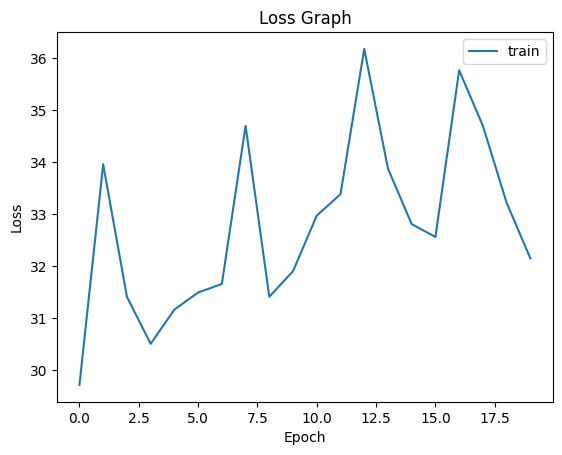

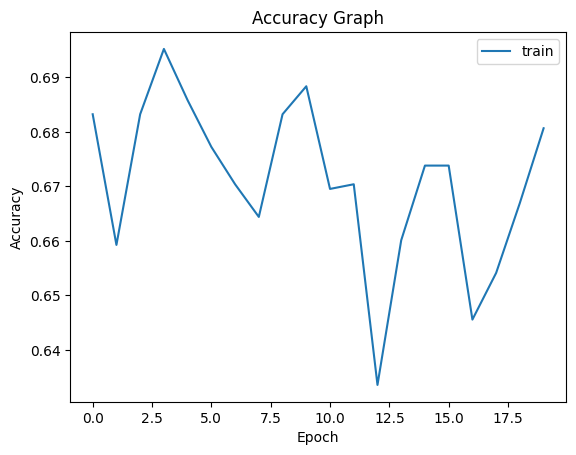

In [43]:
# Function to plot loss and accuracy
def plot_metrics(train, val=None, name1="train", name2="val", title=""):
    plt.figure()
    plt.title(title)
    plt.plot(train, label=name1)
    if val is not None:
        plt.plot(val, label=name2)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(title.split()[0])  # Use "Loss" or "Accuracy" as y-label
    plt.show()

# Plot loss and accuracy
plot_metrics(train_loss, title="Loss Graph")
plot_metrics(train_accuracy, title="Accuracy Graph")
relation_accuracy = train_accuracy[-1]

### Final Results

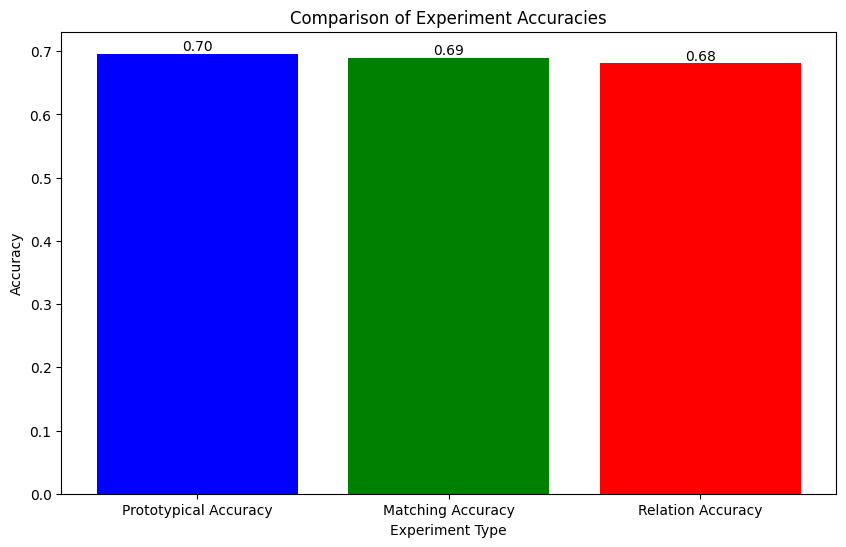

In [44]:

# Accuracy values
accuracies = [prototypical_accuarcy, matching_accuracy, relation_accuracy]
labels = ['Prototypical Accuracy', 'Matching Accuracy', 'Relation Accuracy']

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=['blue', 'green', 'red'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Add titles and labels
plt.title('Comparison of Experiment Accuracies')
plt.xlabel('Experiment Type')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

In [45]:
# Calculate and print the best accuracy
best_accuracy = max(accuracies)
best_accuracy_label = labels[accuracies.index(best_accuracy)]
print(f"The best accuracy is {best_accuracy_label} with a value of {best_accuracy:.2f}")

# Calculate and print the range of diversity
accuracy_range = max(accuracies) - min(accuracies)
print(f"The range of diversity between the accuracies is {accuracy_range:.2f}")

The best accuracy is Prototypical Accuracy with a value of 0.70
The range of diversity between the accuracies is 0.02
